In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import warnings
import os
import sys

sys.path.append(os.path.abspath('..'))
warnings.simplefilter(action='ignore', category=FutureWarning)

# Caricamento del dataset
filename = '../data/raw/training_data.csv'
try:
    df = pd.read_csv(filename)
    print("Dataset caricato correttamente.")
except FileNotFoundError:
    print(f"Errore: il file '{filename}' non è stato trovato.")  

Dataset caricato correttamente.


### **Struttura del Dataset**

Di seguito verrà effettuata una prima analisi della struttura del dataset (numero di righe, numero di colonne, missing values, evoluzione dei sensori nel tempo, correlazione sensori vs target e distribuzione dei target).

In [2]:
# Configurazione stile grafici
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Ispezione struttura e tipi di dato
print("\n--- Informazioni sul Dataset ---")
print(df.info())

print("\n--- Prime 5 righe ---")
print(df.head())
        
print("\n--- Controllo Valori Mancanti ---")
missing = df.isnull().sum()
print(missing[missing > 0])

print(f"\n--- Numero di Motori (ESN) unici nel dataset: {df['ESN'].nunique()} ---")
print(f"Lista ESN: {df['ESN'].unique()}")

# Statistiche descrittive per individuare Outlier
print("\n--- Statistiche Descrittive ---")
print(df.describe())

# Ordinamento del DataFrame per ESN, Cycles_Since_New e Snapshot
df = df.sort_values(by=['ESN', 'Cycles_Since_New', 'Snapshot']).reset_index(drop=True)


--- Informazioni sul Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59702 entries, 0 to 59701
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ESN                 59702 non-null  int64  
 1   Cycles_Since_New    59702 non-null  int64  
 2   Snapshot            59702 non-null  int64  
 3   Cumulative_WWs      59702 non-null  int64  
 4   Cumulative_HPC_SVs  59702 non-null  int64  
 5   Cumulative_HPT_SVs  59702 non-null  int64  
 6   Sensed_Altitude     59702 non-null  float64
 7   Sensed_Mach         59702 non-null  float64
 8   Sensed_Pamb         59702 non-null  float64
 9   Sensed_Pt2          59702 non-null  float64
 10  Sensed_TAT          59702 non-null  float64
 11  Sensed_WFuel        59005 non-null  float64
 12  Sensed_VAFN         59702 non-null  float64
 13  Sensed_VBV          59702 non-null  float64
 14  Sensed_Fan_Speed    59702 non-null  float64
 15  Sensed_Core_Speed  

- Dimensioni: 59.702 righe (osservazioni) e 25 colonne (variabili).

- Tipi di dato:
   - float64: valori dei sensori (`Sensed_*`).
   - int64: contatori interi (indentificativi motori, `ESN`), cicli trascorsi (`Cycles_Since_New`) e le variabili target (`Cycles_to_*`).

- Valori mancanti: ci sono dei buchi nei dati per alcuni sensori specifici.
   - `Sensed_WFuel`, `Sensed_Core_Speed`, `Sensed_T3`, `Sensed_Ps3`, `Sensed_T45`, `Sensed_T5`.
   - In circa 600-750 righe i sensori hanno smesso di registrare o il dato è corrotto.

- Analisi dei motori: ci sono 4 motori (101, 102, 103, 104), quindi le serie storiche sono molto lunghe (circa 15.000 snapshot per motore).

- Statistiche descrittive e outlier: questa parte di analisi rivela dei problemi nei dati.
   - **Temperature impossibili**: `Sensed_T25`, ad esempio, ha una media di circa 925°, un massimo di 895.556° (chiaramente un errore del sensore), e un minimo di -2.379° (sotto lo zero assoluto, fisicamente impossibile). Lo stesso vale per `Sensed_T3`, `Sensed_T45`, `Sensed_T5` (valori massimi di 27.000+ sono irrealistici per temperature di un motore a turbina, solitamente operano sui 600-1500°C).
   - **Pressioni anomale**: in `Sensed_P25` il valore minimo è -19.003, in questo caso la pressione assoluta non può essere negativa. Questo indica un guasto del sensore o un errore di registrazione.

- Variabili target: le colonne `Cycles_to_WW` (Water Wash), `Cycles_to_HPC_SV` (Shop Visit Compressore) e `Cycles_to_HPT_SV` (Shop Visit Turbina) sono ciò che si vuole predire.

**Informazioni del dataset**

| Nome Colonna | Categoria | Descrizione / Significato Fisico |
| :--- | :--- | :--- |
| **ESN** | Metadata | **Engine Serial Number**: Identificativo univoco del motore (es. 101, 102...). |
| **Cycles_Since_New** | Metadata | Età operativa del motore espressa in numero di cicli di volo completati dalla produzione. |
| **Snapshot** | Metadata | Momento di acquisizione dati all'interno di un singolo ciclo (da 1 a 8). Rappresenta diverse condizioni di volo. |
| **Cumulative_WWs** | Metadata | Numero cumulativo di lavaggi del compressore (**Water Wash**) effettuati. |
| **Cumulative_HPC_SVs** | Metadata | Numero cumulativo di revisioni in officina (**Shop Visits**) del Compressore ad Alta Pressione. |
| **Cumulative_HPT_SVs** | Metadata | Numero cumulativo di revisioni in officina della Turbina ad Alta Pressione. |
| **Sensed_Altitude** | Sensore (Op.) | Altitudine di volo misurata (piedi). |
| **Sensed_Mach** | Sensore (Op.) | Numero di Mach (velocità dell'aereo). |
| **Sensed_Pamb** | Sensore (Op.) | Pressione ambientale statica. |
| **Sensed_Pt2** | Sensore | Pressione totale all'ingresso del motore (Fan Inlet). |
| **Sensed_TAT** | Sensore (Op.) | **Total Air Temperature**: Temperatura totale dell'aria esterna. |
| **Sensed_WFuel** | Sensore | Flusso di carburante (**Fuel Flow**). |
| **Sensed_VAFN** | Sensore (Att.) | **Variable Area Fan Nozzle**: Posizione dell'attuatore dell'ugello del fan. |
| **Sensed_VBV** | Sensore (Att.) | **Variable Bleed Valve**: Posizione della valvola di spurgo. |
| **Sensed_Fan_Speed** | Sensore | Velocità di rotazione della ventola (**N1** - Low Pressure Spool). |
| **Sensed_Core_Speed** | Sensore | Velocità di rotazione del nucleo (**N2** - High Pressure Spool). |
| **Sensed_P25** | Sensore | Pressione all'ingresso dell'HPC. |
| **Sensed_T25** | Sensore | Temperatura all'ingresso dell'HPC. |
| **Sensed_Ps3** | Sensore | Pressione statica all'uscita dell'HPC (ingresso combustore). |
| **Sensed_T3** | Sensore | Temperatura all'uscita dell'HPC. |
| **Sensed_T45** | Sensore | Temperatura all'uscita dell'HPT (Inter-turbine temperature). |
| **Sensed_T5** | Sensore | Temperatura all'uscita della LPT (Exhaust Gas Temperature). |
| **Cycles_to_WW** | Target (Y) | **RUL Water Wash**: Cicli rimanenti al prossimo lavaggio. |
| **Cycles_to_HPC_SV** | Target (Y) | **RUL HPC**: Cicli rimanenti alla prossima revisione del compressore. |
| **Cycles_to_HPT_SV** | Target (Y) | **RUL HPT**: Cicli rimanenti alla prossima revisione della turbina. |


---

### **Evoluzione dei Sensori nel Tempo**

Verranno plottate le serie temporali dei sensori lungo l'intero ciclo di volo, per avere una prima idea del loro comportamento nel tempo, cercando di individuare zone piatte tipiche di condizioni stabili, e zone dinamiche, caratteristiche dei transitori.

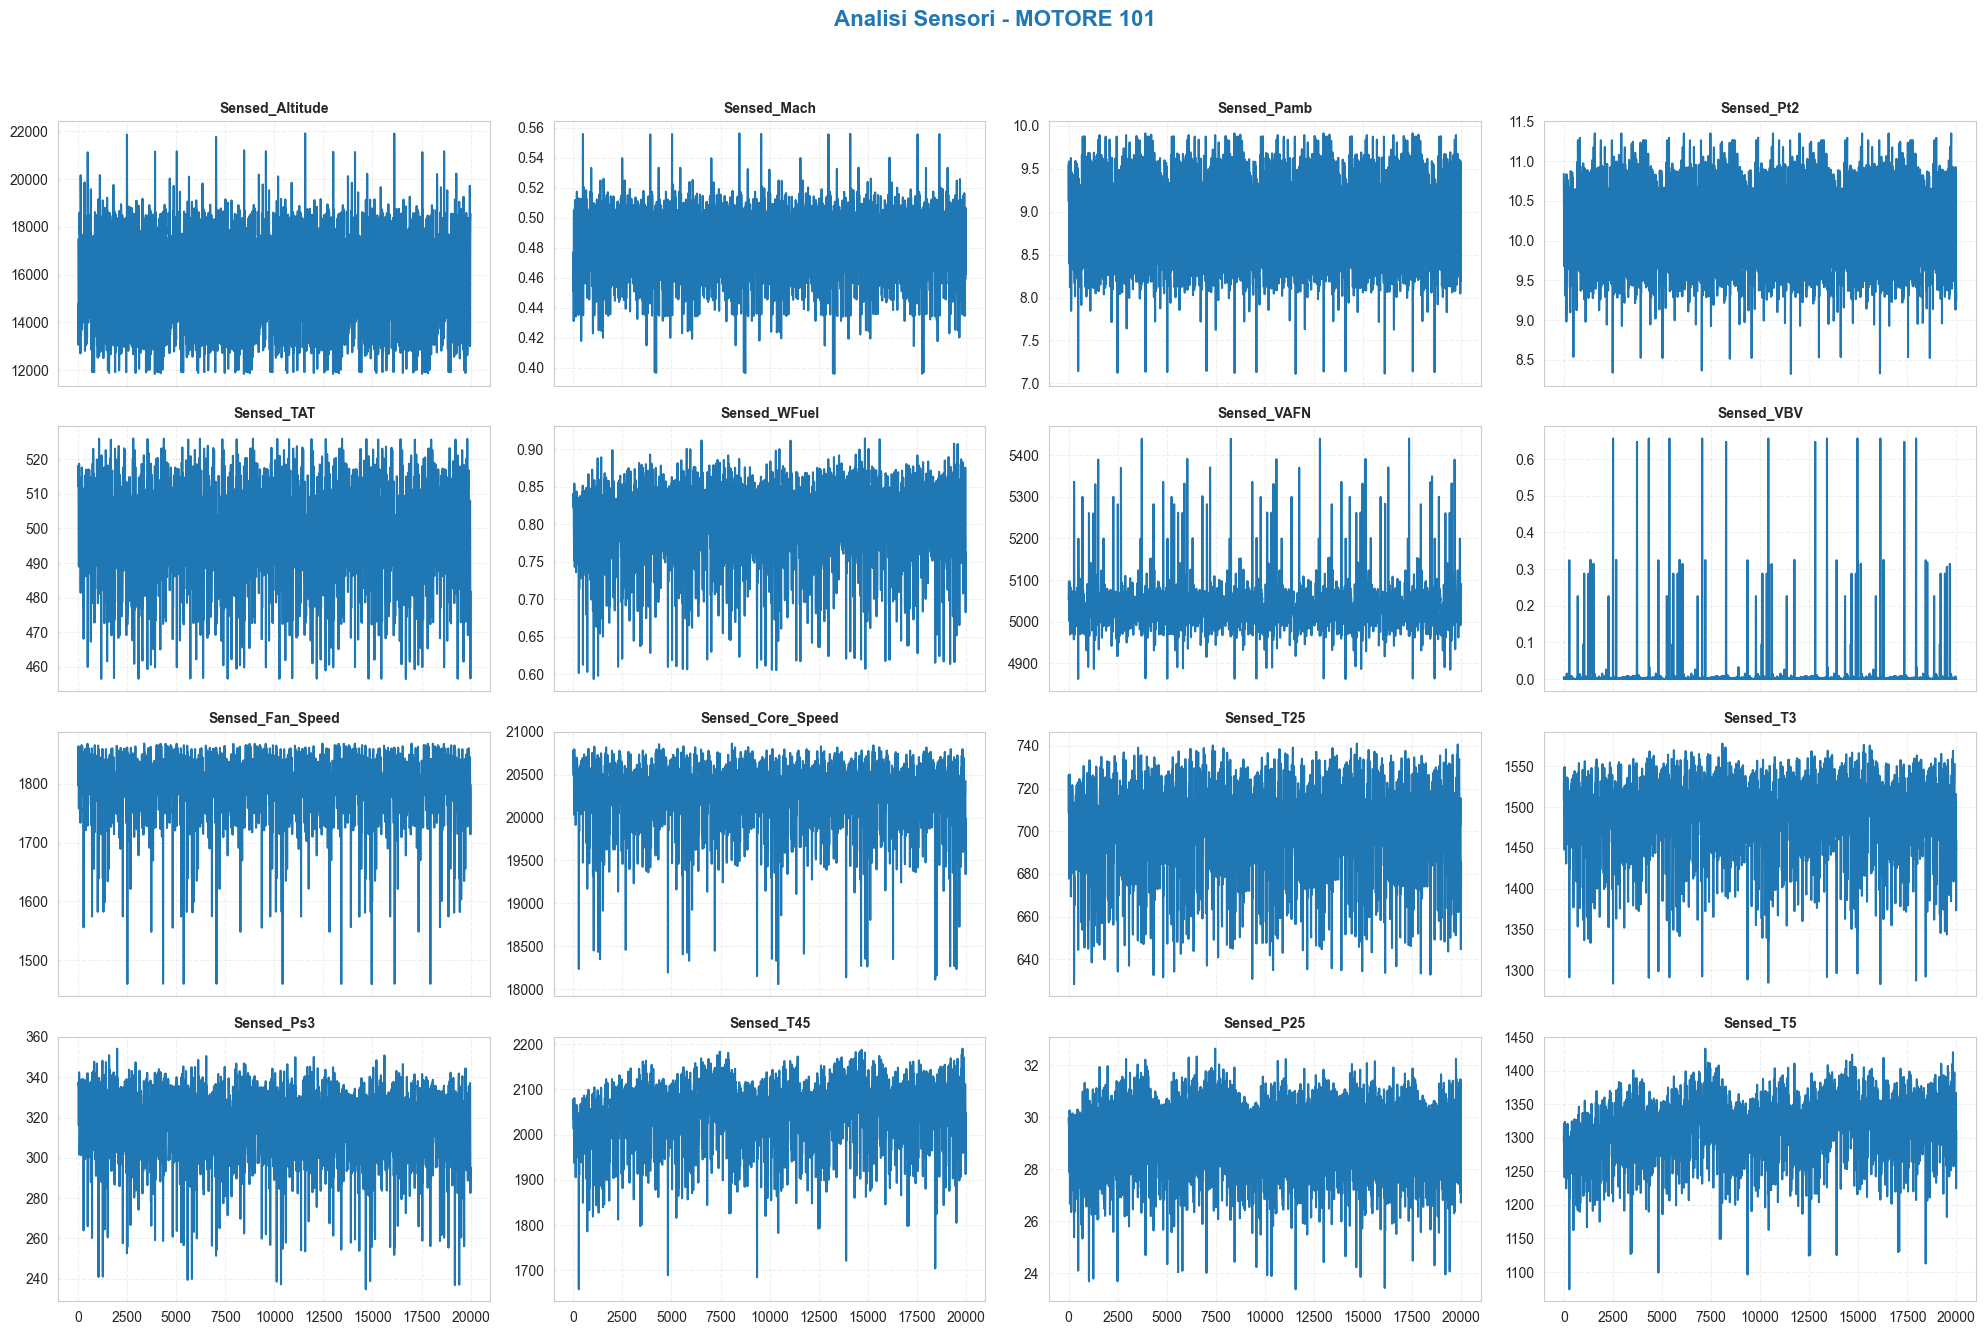

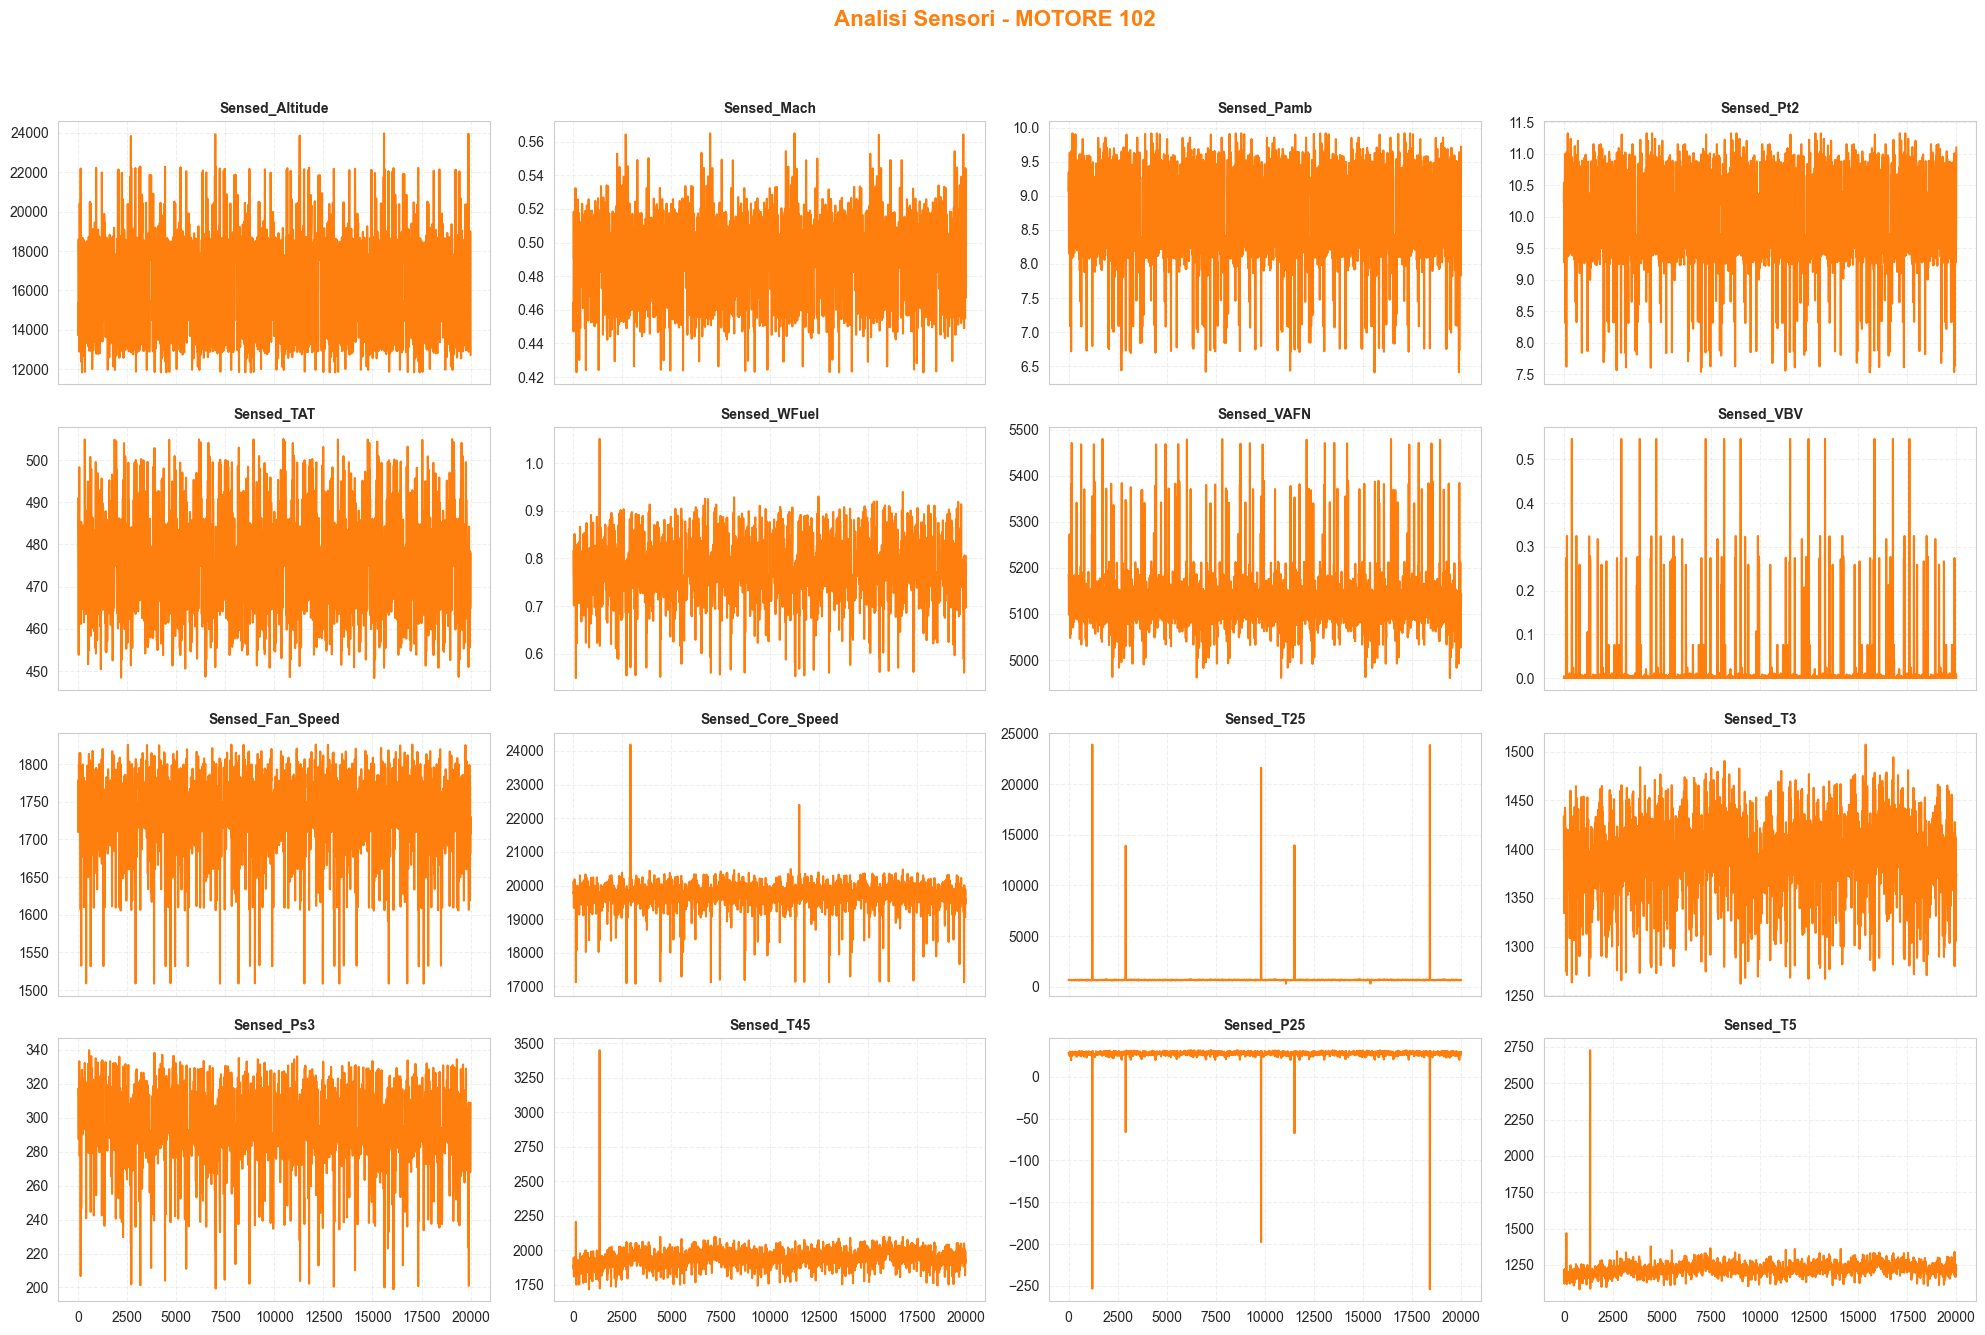

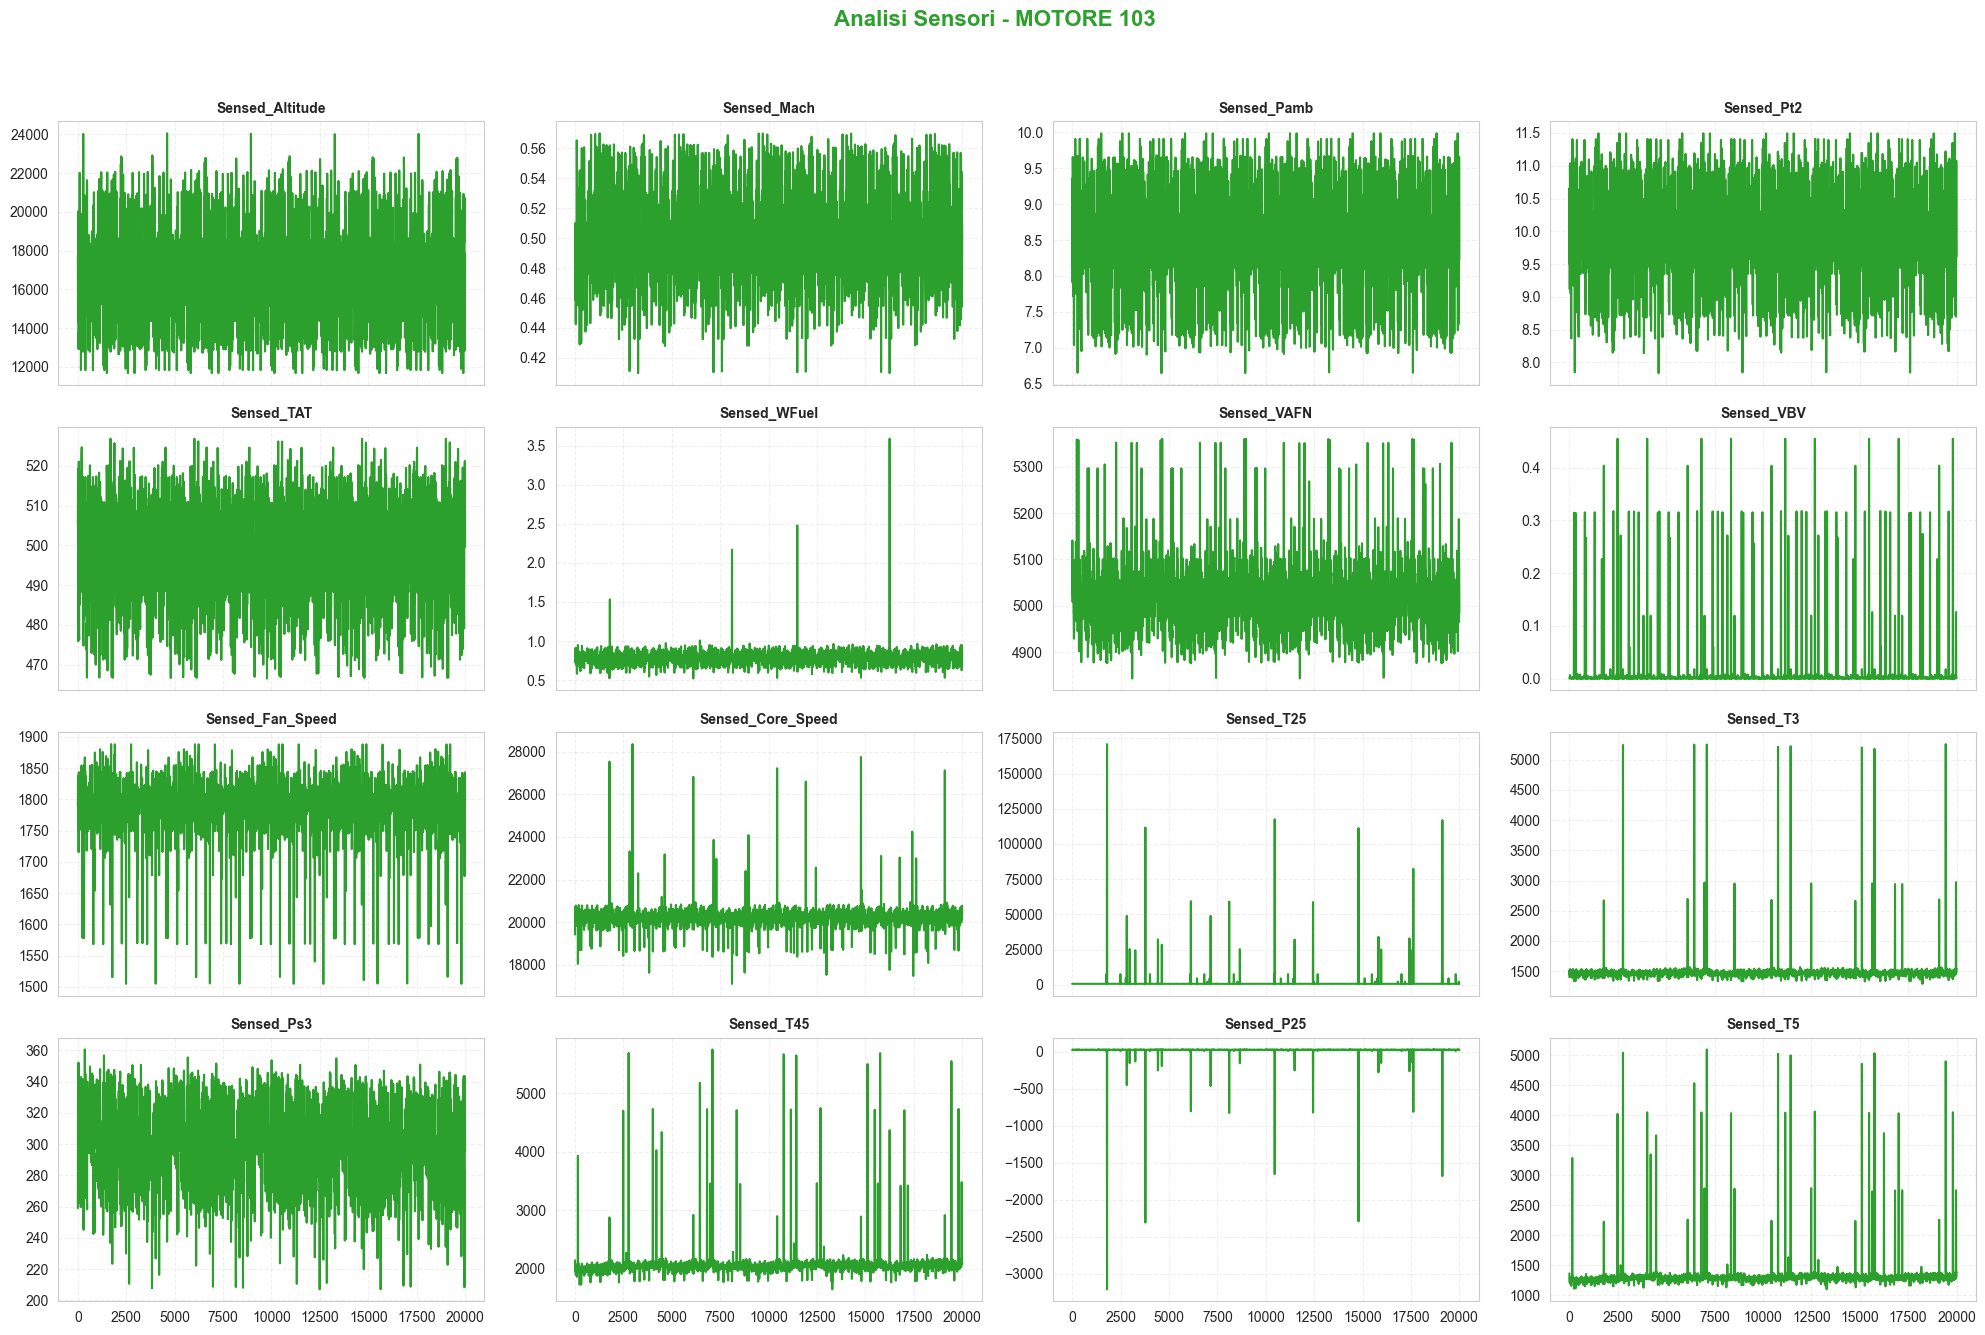

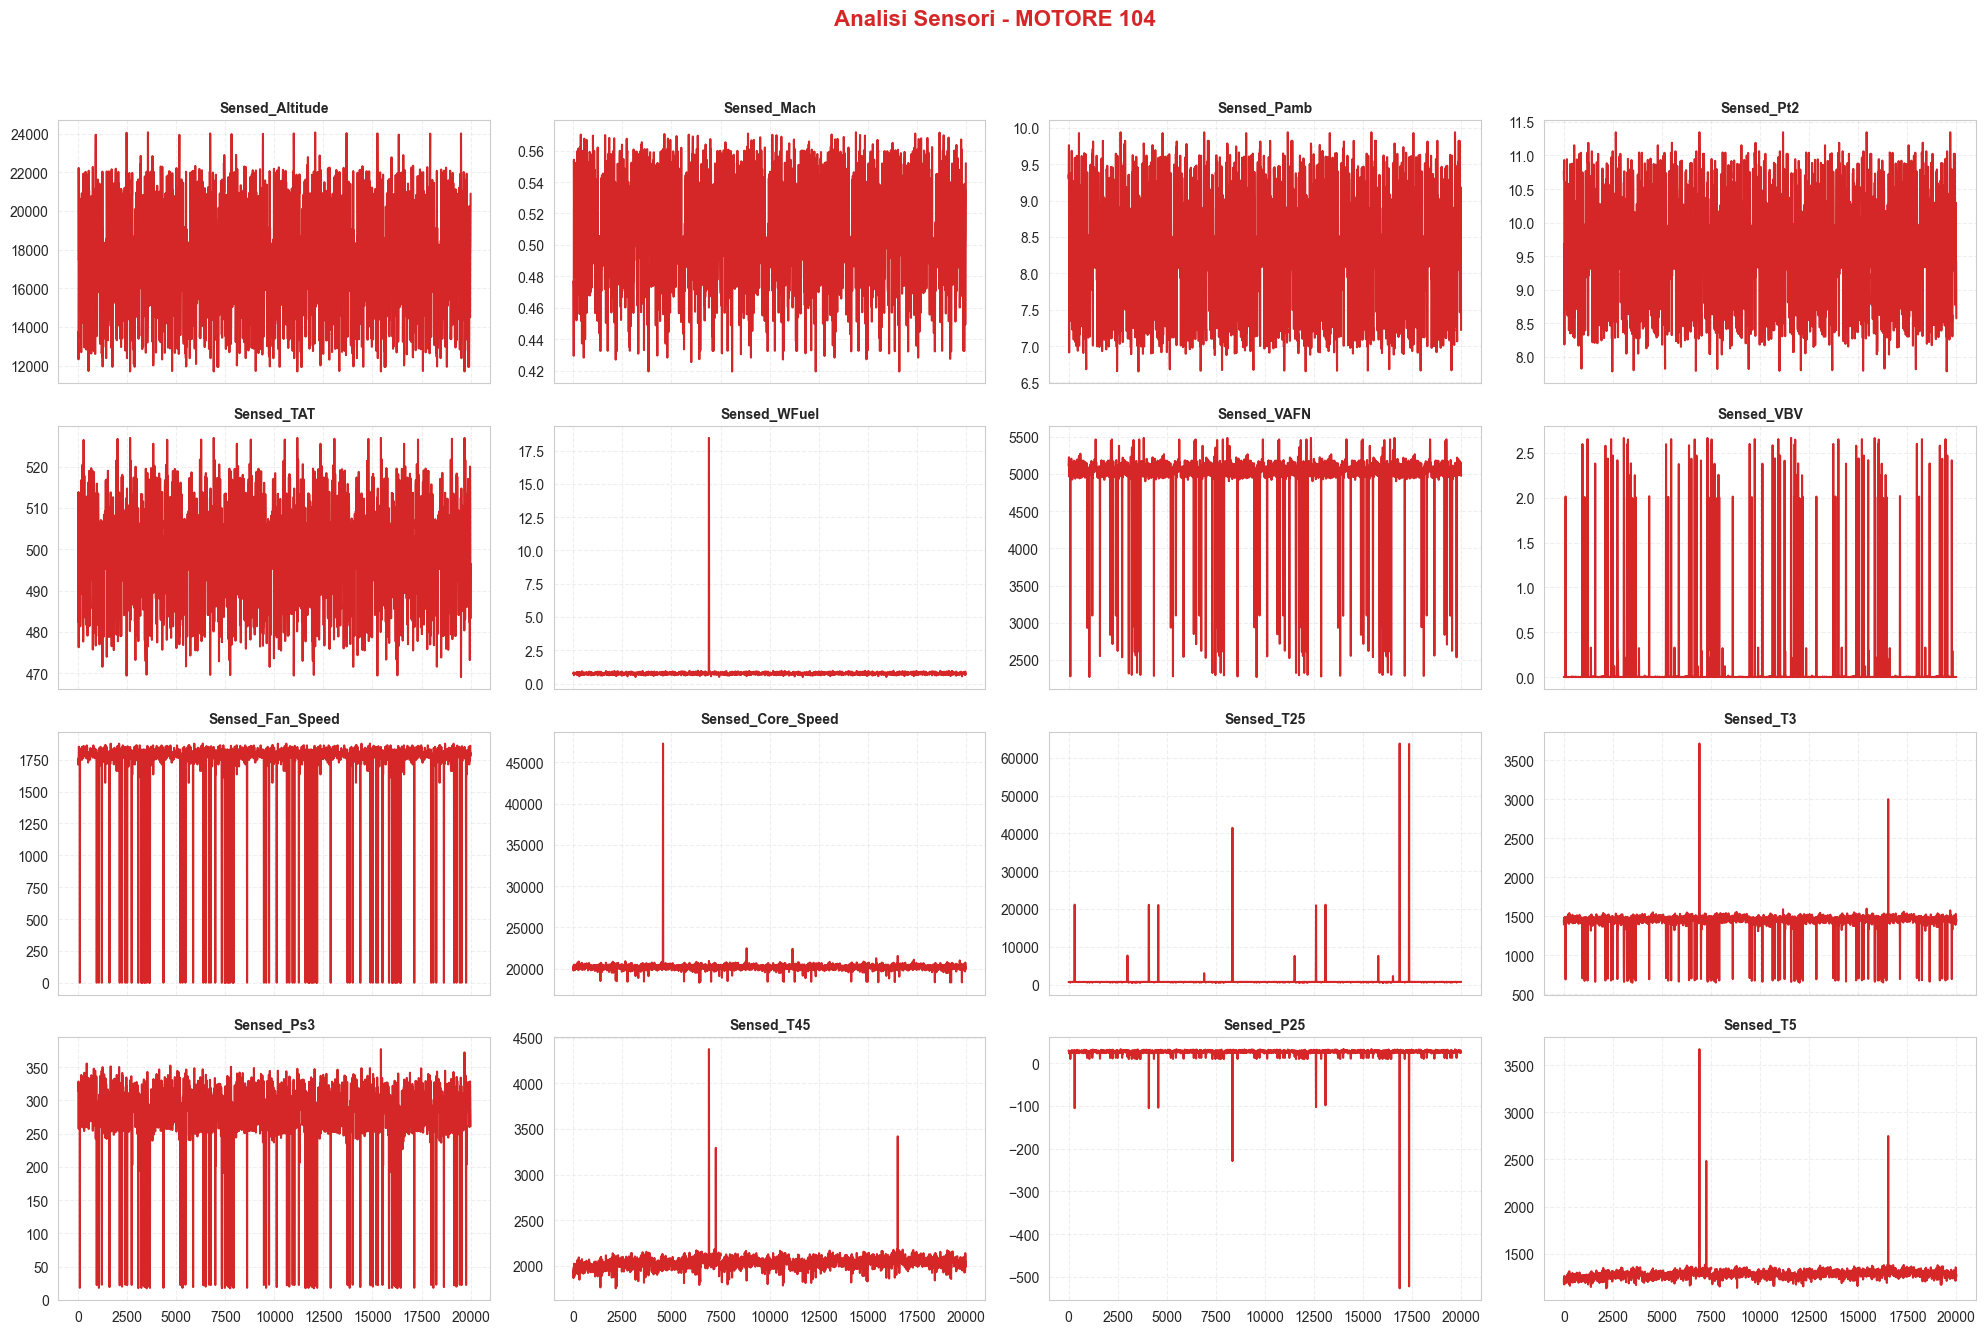

In [3]:
sensors_list = [
            'Sensed_Altitude', 'Sensed_Mach', 'Sensed_Pamb', 'Sensed_Pt2',
            'Sensed_TAT', 'Sensed_WFuel', 'Sensed_VAFN', 'Sensed_VBV',
            'Sensed_Fan_Speed', 'Sensed_Core_Speed', 'Sensed_T25', 'Sensed_T3',
            'Sensed_Ps3', 'Sensed_T45', 'Sensed_P25', 'Sensed_T5'
        ]

def sensor_plot(df, sensors_list=sensors_list):
    """
    Funzione per plottare i sensori per ogni motore (ESN).
    Ogni grafico mostra l'andamento medio del sensore in funzione dei cicli.
    """

    unique_esns = sorted(df['ESN'].unique())
    
    # Calcolo dinamico delle dimensioni della griglia
    n_sensors = len(sensors_list)
    cols = 4
    rows = math.ceil(n_sensors / cols)
    
    # Mappa colori specifica per il training set
    color_map_fixed = {101: 'tab:blue', 102: 'tab:orange', 103: 'tab:green', 104: 'tab:red'}
    # Colori di fallback per altri motori (es. test set)
    fallback_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # --- LOOP SUI MOTORI ---
    for idx, esn in enumerate(unique_esns):
        
        # Altezza figura dinamica in base alle righe
        fig, axes = plt.subplots(rows, cols, figsize=(20, 3.5 * rows))
        
        # Determina il colore
        if esn in color_map_fixed:
            line_color = color_map_fixed[esn]
        else:
            line_color = fallback_colors[idx % len(fallback_colors)]
            
        fig.suptitle(f'Analisi Sensori - MOTORE {esn}', fontsize=16, fontweight='bold', color=line_color)
        
        axes = axes.flatten()
        subset_esn = df[df['ESN'] == esn]

        for i, sensor in enumerate(sensors_list):
            ax = axes[i]
            
            if sensor in df.columns:
                # Aggregazione per ciclo
                subset_agg = subset_esn.groupby('Cycles_Since_New')[sensor].mean()
                
                ax.plot(subset_agg.index, subset_agg.values, color=line_color, linewidth=1.5)
                
                ax.set_title(sensor, fontsize=10, fontweight='bold')
                ax.grid(True, alpha=0.3, linestyle='--')
                
                if i < (rows - 1) * cols:
                    ax.set_xticklabels([])
            else:
                ax.text(0.5, 0.5, 'N/A', ha='center', va='center', color='gray')
                ax.set_title(f"{sensor} (Mancante)", fontsize=9)
        
        for k in range(i + 1, len(axes)):
            axes[k].axis('off')
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

sensor_plot(df)

#### **Esempio primo motore** 

Prendendo come esempio il primo motore (101 - grafici blu), si possono osservare vari comportamenti interessanti su questi sensori, che non mostrano l'usura del motore, ma le condizioni operative:
- **Rumore**: le linee sono molto seghettate e oscillano continuamente. Questo perché un aereo vola a quote, velocità e pressioni diverse in ogni ciclo.
- **Correlazione fisica**: si può osservare come `Sensed_Altitude` e `Sensed_Pamb` sono speculari; quando l'altitudine sale, la pressione scende.
- **Importante per il PHM**: questo rumore nasconde il vero segnale di guasto (*ad esempio: il motore è caldo perché si sta rompendo o perché semplicemente l'aereo sta decollando nel deserto?*)

In sintesi, i grafici confermano che i dati sono rumorosi e contaminati, con una variabilità operativa fluttuante pesantemente a seconda della missione di volo (Altitudine/Mach) e con la presenza di artefatti (errori di misurazione) che rendono impossibile vedere il trend di degradazione reale ad occhio nudo.

#### **Similarità e differenze tra i motori**

Dall'esame visivo dei grafici generati per i 16 sensori sui 4 motori disponibili nel training set, emergono pattern distinti che suggeriscono una divisione netta tra il comportamento "nominale" e la presenza di anomalie nei dati.

**1. Similitudini: Profilo di Missione e Fisica del Degrado**

Tutti i motori mostrano coerenza nelle condizioni operative e nei trend macroscopici di invecchiamento.

* **Condizioni Operative Identiche:** I sensori di input ambientale e di comando (`Sensed_Altitude`, `Sensed_Mach`, `Sensed_Pamb`, `Sensed_Pt2`) mostrano distribuzioni dense e uniformi per tutti i motori. Questo conferma che l'intera flotta opera su profili di missione simili; non vi sono bias operativi evidenti su un singolo motore.
* **Trend di Degrado Comune:** I sensori termodinamici critici (`Sensed_T45`, `Sensed_T5`, `Sensed_Ps3`) mostrano per tutti i motori una tendenza di fondo (background trend) comune: le temperature tendono a salire e l'efficienza a calare all'aumentare dei `Cycles_Since_New`. Questo riflette la fisica corretta dell'usura del motore.

**2. Differenze Critiche: Qualità del Dato e Outlier**

La distinzione principale risiede nella "pulizia" del segnale e nella presenza di eventi impulsivi (spikes).

* **"Motore Pulito" (ESN 101):**
    * I dati appaiono visivamente stabili e contenuti all'interno di fasce ben definite.
    * Non sono presenti picchi estremi isolati che escono dalla scala logica del sensore.
    * Rappresenta il *best-case scenario* per l'addestramento.

* **Motori Rumorosi" (ESN 102, 103, 104):**
    * Questi motori presentano frequenti anomalie sotto forma di **picchi verticali (spikes)** che rompono la continuità del trend.
    * **Anomalie evidenti**:
        * **Flusso Carburante (`Sensed_WFuel`):** Picchi isolati verso l'alto (in particolare su 103 e 104) con valori doppi rispetto alla media.
        * **Pressione (`Sensed_P25`):** Crolli improvvisi verso il basso (valori vicini allo zero o anomali) visibili nettamente su 103 e 104, assenti sul 101.
        * **Temperature:** Picchi istantanei verso l'alto su $T_{25}$ e $T_3$ (motore 102 e 104).

---

### **Matrice di Correlazione (Sensori vs Target)**

Di seguito verrà plottata una **matrice di correlazione** tra sensori (feature) e target, che descrive quanto e come ogni variabile osservata influenza o è stata associata al fenomeno che si vuole prevedere. Se un sensore mostra **alta correlazione** con il target significa che contiene informazione utile, è un buon candidato per il modello. Inoltre, è possibile osservare se esistono delle **variabili ridondanti**, per eliminarle dal dataset ed evitare l'overfitting.

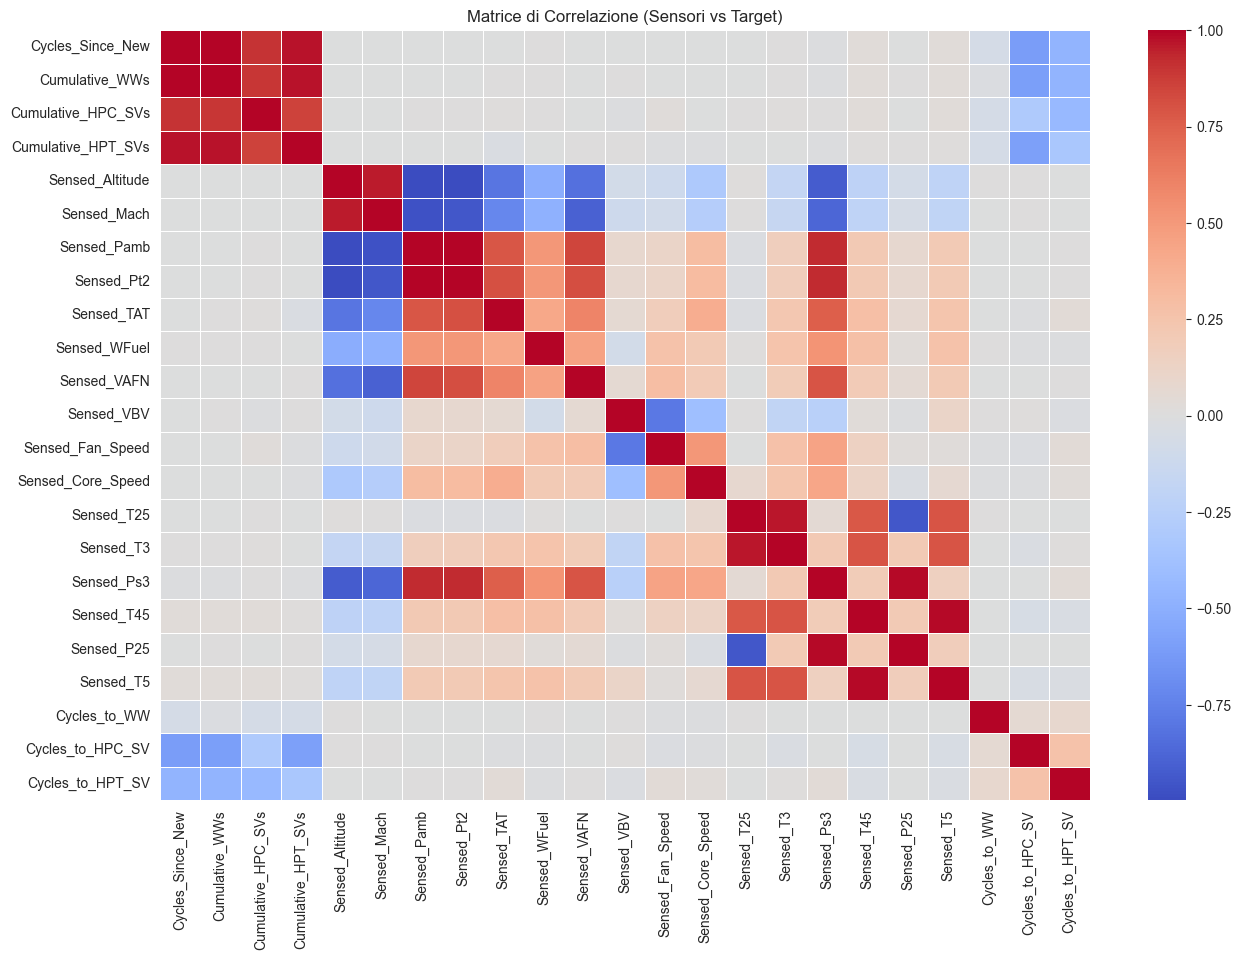

In [4]:
# Matrice di correlazione
plt.figure(figsize=(15,10))
cols_to_drop = ['ESN', 'Snapshot']
corr_matrix = df.drop(columns=[c for c in cols_to_drop if c in df.columns]).corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Matrice di Correlazione (Sensori vs Target)')
plt.show()

La matrice mostra innanzitutto che il **rumore sovrasta il segnale**: infatti, la parte più colorata (rossa e blu intensa) si trova tra i sensori stessi. Questo significa che i sensori sono **fortemente correlati tra loro** a causa della fisica del volo, non a causa del guasto (come è stato osservato, ad esempio, se l'aereo sale la pressione scende). Queste correlazioni fisiche sono così forti che sovrastano i segnali di degrado del motore, quindi il modello rischia di imparare a riconoscere se l'aereo sta decollando o atterrando, invece di capire se si sta rompendo.

Inoltre, si può osservare come i **target sono correlati tra loro**, poiché man mano che il tempo passa, tutti i contatori alla rovescia scendono insieme. Questo indica che i diversi tipi di usura procedono parallelamente nel tempo.

La parte più importante si nota tra le ultime righe/colonne che incrociano i sensori con i target: qui i colori sono tenui, indicando una correlazione debole. Ciò significa che **nessun sensore singolo è un predittore perfetto della vita residua**.

---

### **Distribuzione dei Target (Remaining Useful Life)**

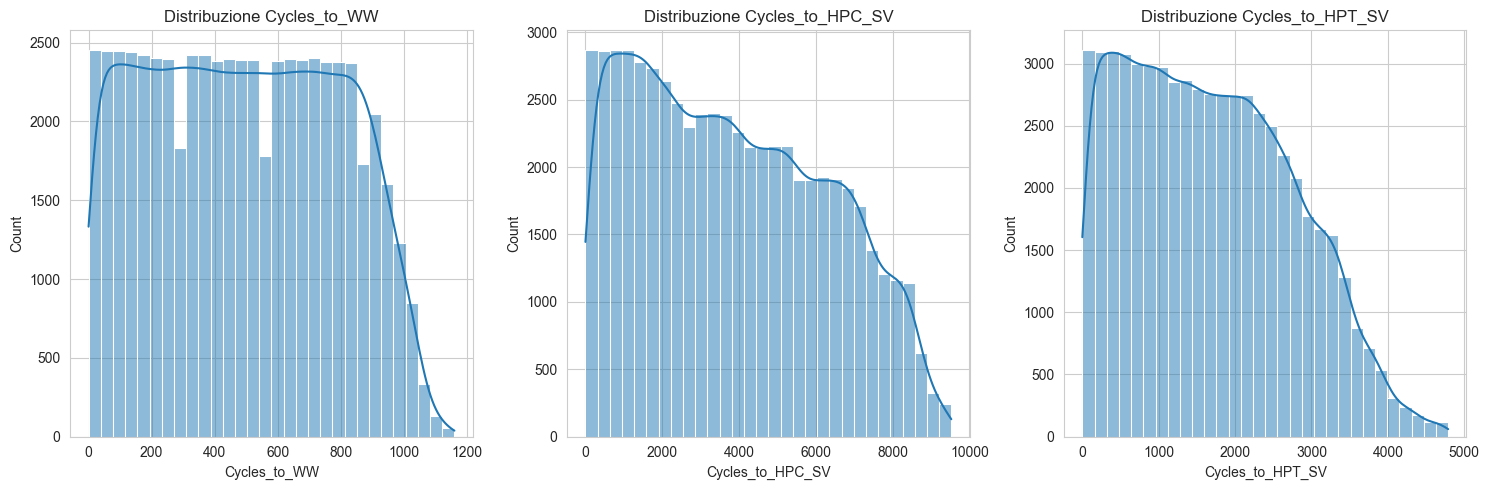

In [5]:
# Distribuzione dei Target (Remaining Useful Life)
target_cols = ['Cycles_to_WW', 'Cycles_to_HPC_SV', 'Cycles_to_HPT_SV']

plt.figure(figsize=(15, 5))
for i, target in enumerate(target_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[target], kde=True, bins=30, color='tab:blue')
    plt.title(f'Distribuzione {target}')
plt.tight_layout()
plt.show()

La prima cosa che salta all'occhio osservando i grafici è la forma frastagliata con **molteplici picchi**. Questo accade perché i dati provengono da solo 4 motori, probabilmente ogni picco è dovuto alla storia di vita di uno specifico motore. Il dataset, quindi, non è denso e il modello potrebbe rischiare di memorizzare le specificità di questi motori, invece di imparare regole generali del guasto (overfitting).

- `Cycles_to_WW` (Water Wash - Lavaggio):
   - Da 0 a circa 1200 cicli;
   - Distribuzione molto concentrata verso sinistra;
   - Interpretazione operativa: il lavaggio del motore è un evento di manutenzione **frequente**;
   - Il modello avrà molti esempi di questo evento, rendendo più **semplice** la sua previsione.

- `Cycles_to_HPC_SV` (Compressore Alta Pressione - Shop Visit):
   - Da 0 a quasi 10.000 cicli;
   - Distribuzione molto estesa e piatta;
   - Interpretazione operativa: **manutenzione a lungo termine**, quindi il compressore dura molto.
   - Essendo un evento raro, predire con precisione se mancano 8.000 o 8.500 cicli sarà **difficile**.

- `Cycles_to_HPT_SV` (Turbina Alta Pressione - Shop Visit):
   - Da 0 a circa 5.000 cicli;
   - Distribuzione intermedia tra le due precedenti;
   - Interpretazione operativa: la turbina si usura più velocemente del compressore (dato che è esposta ad alte temperature), ma meno frequentemente dei lavaggi;
   - Spesso è il **target più critico**, poiché un guasto alla turbina è catastrofico e costoso.

Questi grafici indicano problemi di **scale diverse**: si sta cercando di predire cose che accadono in un range di frequenze molto ampio, quindi l'errore assoluto (RMSE) sarà ingannevole. Sbagliare di 100 cicli sul `Cycles_to_WW` è un errore enorme (10% della vita), sbagliare di 100 cicli sul `Cycles_to_HPC_SV` è irrilevante (1%).

---

### **Analisi Statistica Descrittiva Globale**

Di seguito vengono calcolate le seguenti metriche di base sull'intero dataset per un benchmark iniziale:

- **Varianza** e **Deviazione Standard**, per quantificare la dispersione globale.

- **Valore Efficace (RMS)**, per capire l'energia complessiva del segnale.

- **Kurtosis**, per rilevare la presenza di picchi o eventi impulsivi (che sono comuni nella fase di atterraggio) rispetto ad una distribuzione normale.

Inoltre, verranno creati dei **boxplot** per ogni sensore, in modo tale da individuare gli outlier per indagare sulla variabilità dei dati dei sensori.


--- Statistiche Globali dei Sensori ---
               Sensor      Variance       Std_Dev           RMS      Kurtosis
0     Sensed_Altitude  1.508762e+08  12283.169365  20711.078043     -1.623396
1         Sensed_Mach  5.314077e-02      0.230523      0.546866     -1.246824
2         Sensed_Pamb  1.808237e+01      4.252336      9.564250     -1.636344
3          Sensed_Pt2  1.329799e+01      3.646641     10.534639     -1.628133
4          Sensed_TAT  8.272699e+02     28.762299    492.995504     -0.759224
5        Sensed_WFuel  3.735561e-01      0.611192      0.992071  27293.849845
6         Sensed_VAFN  7.022347e+05    837.994441   5104.587682      4.418221
7          Sensed_VBV  1.169821e-01      0.342027      0.344184    139.565084
8    Sensed_Fan_Speed  4.895462e+04    221.256919   1771.822295     46.975787
9   Sensed_Core_Speed  2.263172e+06   1504.384274  20149.928996   7343.358464
10         Sensed_T25  9.592557e+07   9794.159991   9837.717601   4323.125257
11          Sensed_T3  

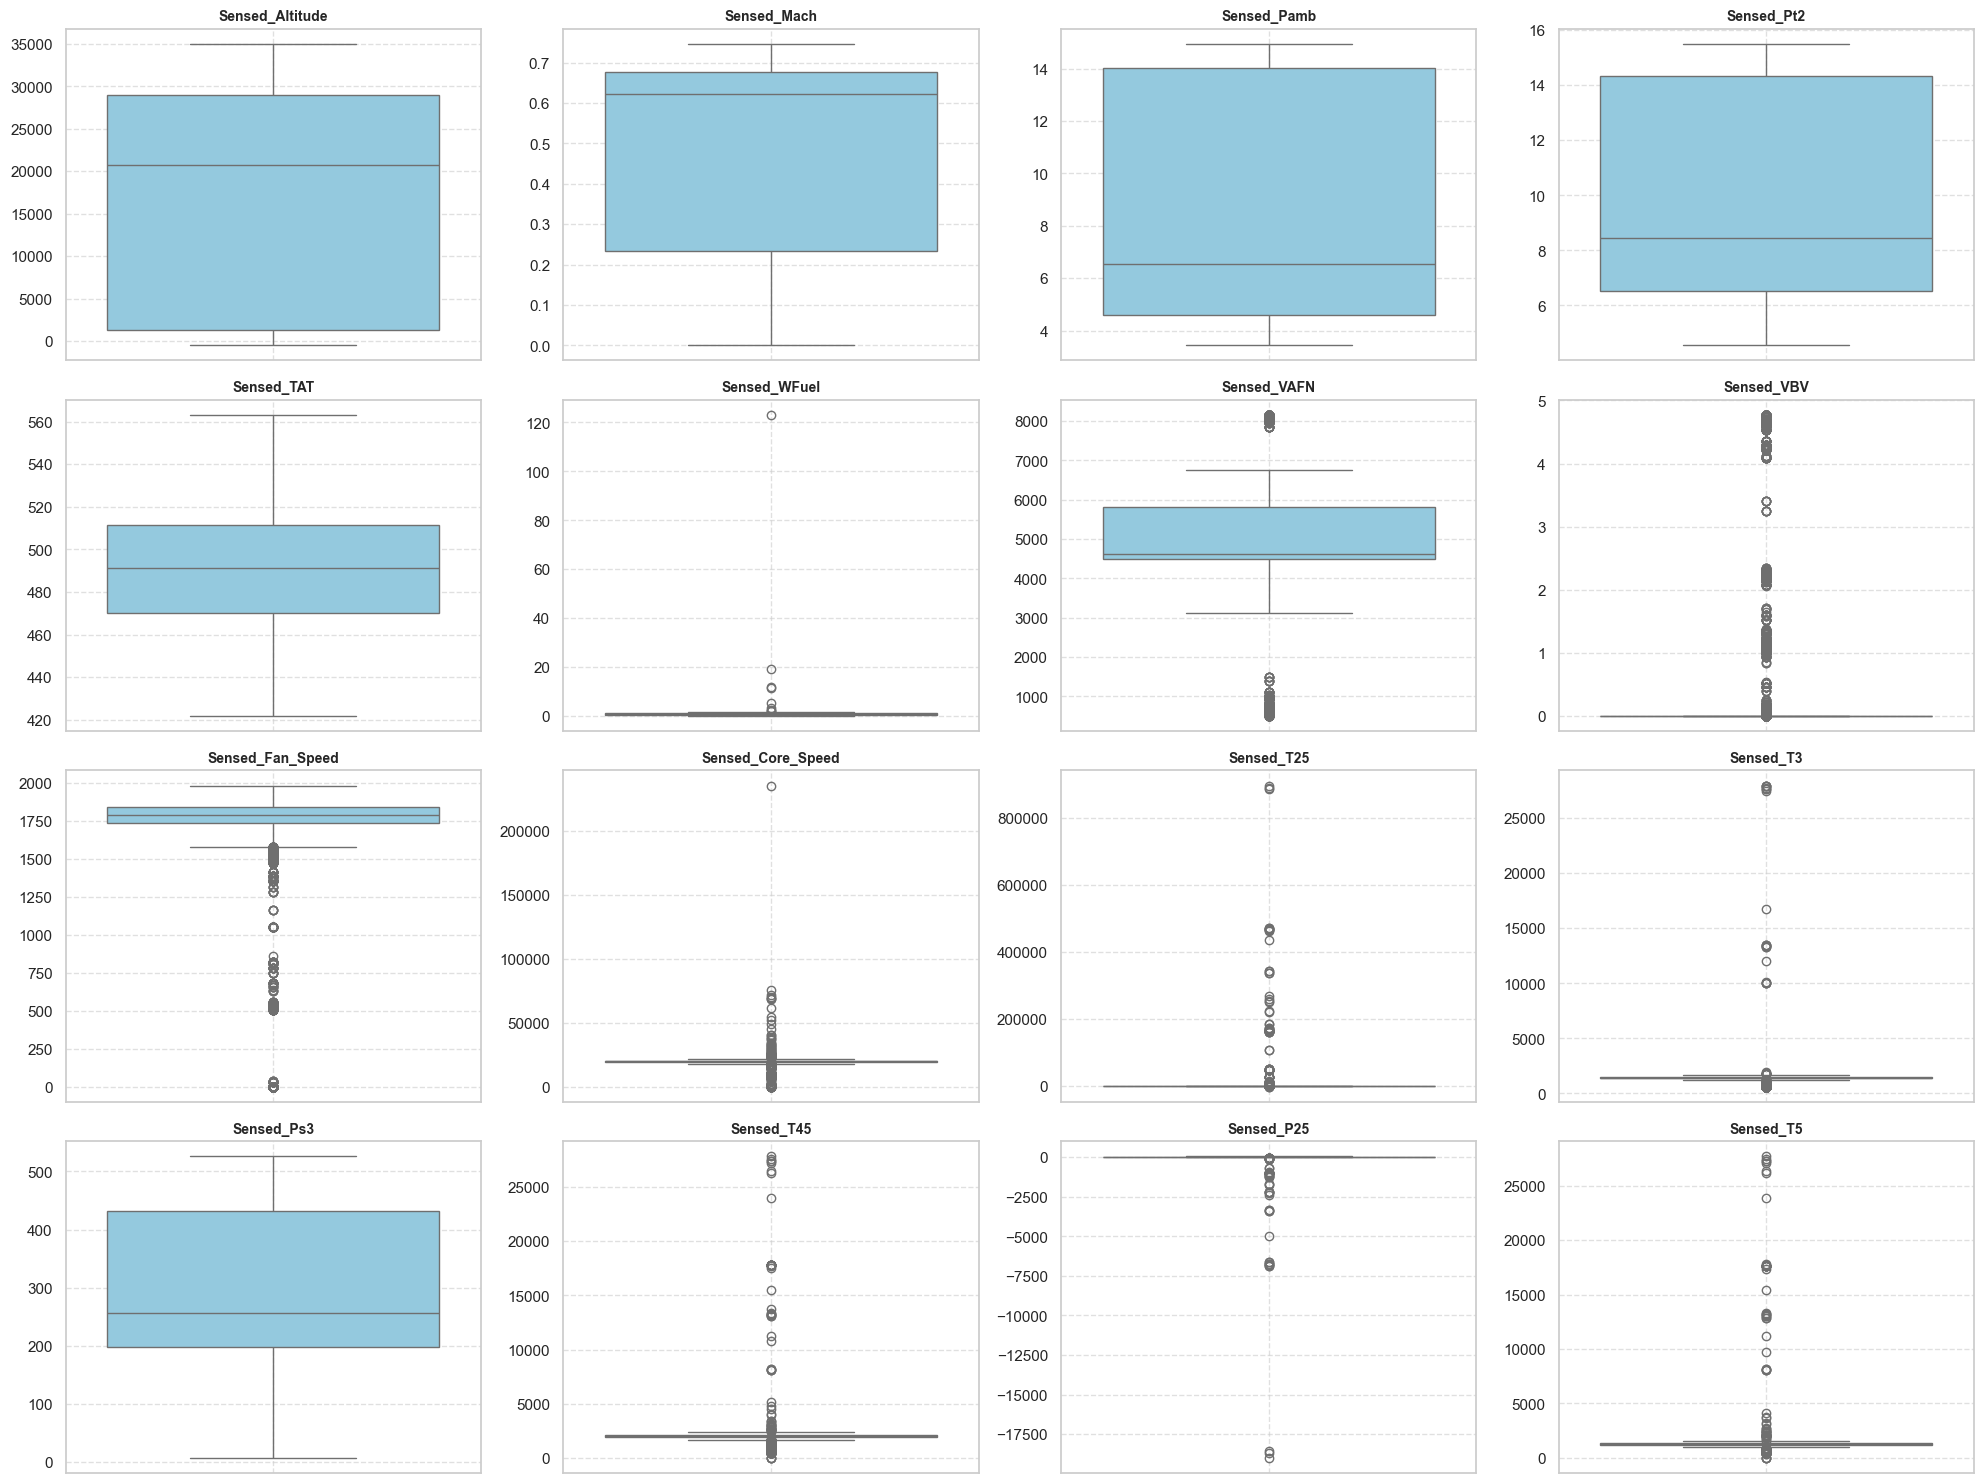

In [6]:
sns.set_theme(style="whitegrid")

def calculate_global_stats(df, sensors_list):
    """
    Calcola Varianza, Std Dev, RMS e Kurtosis per ogni sensore.
    """
    stats_list = []
    
    for sensor in sensors_list:
        if sensor in df.columns:
            series = df[sensor].dropna() # Rimozione NaN
            
            # 1. Varianza e Std Dev (Dispersione rispetto alla media)
            var = series.var()
            std_dev = series.std()
            
            # 2. RMS - Root Mean Square (Energia del segnale)
            rms = np.sqrt(np.mean(series**2))
            
            # 3. Kurtosis (Picco e code della distribuzione)
            kurt = series.kurtosis()
            
            stats_list.append({
                'Sensor': sensor,
                'Variance': var,
                'Std_Dev': std_dev,
                'RMS': rms,
                'Kurtosis': kurt
            })
        
        else:
            print(f"Attenzione: il sensore '{sensor}' non è presente nel DataFrame.")
            
    return pd.DataFrame(stats_list)

def plot_sensor_boxplots(df, sensors_list):
    """
    Genera una griglia di boxplot per la viusalizzazione delle
    distribuzioni e gli outlier macroscopici.
    """
    n_cols = 4
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, sensor in enumerate(sensors_list):
        if sensor in df.columns:
            sns.boxplot(y=df[sensor], ax=axes[i], color='skyblue')
            
            axes[i].set_title(sensor, fontweight='bold', fontsize=10)
            axes[i].set_ylabel('')
            
            # Evidenziazione in rosso se ci sono outlier estremi visibili
            axes[i].grid(True, linestyle='--', alpha=0.6)
        else:
            axes[i].set_visible(False)
            
    plt.tight_layout()
    plt.show()
    
stats_df = calculate_global_stats(df, sensors_list)
print("\n--- Statistiche Globali dei Sensori ---")
print(stats_df)

plot_sensor_boxplots(df, sensors_list)
            

#### **1 - Analisi della Kurtosis**

La Kurtosis misura la propensione agli outlier, dove valori superiori a 3 indicano code pesanti.

- **Caso critico**: il sensore `Sensed_WFuel` ha una Kurtosis di **27.293**, indicando che la distribuzione è quasi una "delta di Dirac" (tutti valori concentrati) con pochissimi valori infinitamente lotani dalla media.

- **Altri sensori compromessi**: `Sensed_P25` (9.545), `Sensed_Core_Speed` (7.343), `Sensed_T25` (4.323) e `Sensed_T3` (3.555).

Quindi, non si possono utilizzare questi dati grezzi per l'analisi di variabilità "fine" (taxi vs cruise): calcolando la varianza mobile ora, un singolo picco a 27.000 farebbe sembrare tutto il resto del volo piatto per errore di scala.

I sensori `Sensed_Altitude`, `Sensed_Mach`, `Sensed_Pamb` e `Sensed_Pt2` hanno tutti Kurtosis negativa (tra -1.2 e -1.6). Ciò comporta una distribuzione piatta, che è perfettamente coerente con un profilo di volo: l'aereo passa molto tempo a terra e molto tempo in crociera, creando una distribuzione bimodale senza una campana centrale. Quindi, la loro alta varianza è variabilità **reale e utile** come riferimento per segmentare il volo.

#### **2 - Analisi della Deviazione Standard e Varianza**

Osservando Varianza e Deviazione Standard si può analizzare quanto gli outlier o la naturale dinamica del volo impattano sui dati.

- **Caso "Fisicamente corretto" (Altitude)**: il sensore `Sensed_Altitude` ha una **Std_Dev di ~12.283**, descrivendo come un aereo che opera tra 0 e 40.000 piedi conferma che il dataset copre tutto il profilo di volo, non solo una fase. In questo caso la varianza è informazione utile.
- **Caso "Corrotto dagli Errori" (T25, T3, T5)**: prendendo come esempio `Sensed_T25`, ha una **Std_Dev di ~9.794**. Questo è fisicamente impossibile per un processo continuo normale, poiché la temperatura all'ingresso di un compressore varia solitamente di qualche centinaio di gradi, non fino a diecimila. In questo caso, la deviazione standard non misura la variabilità del processo.

#### **3 - Analisi dell'RMS (Valore Efficace)**

L'RMS rappresenta l'energia totale del segnale e, confrontandolo con la Deviazione Standard, si può capire la natura del segnale.

- **Segnali con componente DC dominante**: il sensore `Sensed_Core_Speed` ha **RMS (20.149) >> Std_Dev (1.504)**. Ciò significa che il segnale è sano (a parte gli outliers), c'è un valore medio di rotazione molto alto (il motore gira veloce) e la variabilità (accelerazioni/decelerazioni) è una frazione del totale.

- **Segnali dominati dal Rumore/Errore**: il sensore `Sensed_T25` ha **RMS (9.837) ≃ Std_Dev (9.794)**, quindi i valori dovrebbero avere un valore medio stabile. Ciò significa che il valore medio fisico è trascurabile rispetto alla dispersione causata dagli errori. In pratica, il segnale utile è stato mangiato dal rumore degli outlier.

#### **4 - Il paradosso di WFuel**

Per il sensore `Sensed_WFuel` si può notare una Kurtosis elevatissima (27.293) e una Varianza molto bassa (0.37). Può significare che il sensore è normalizzato o in unità molto piccole, ma è costituito quasi interamente da un valore costante con rarissimi picchi (si può notare anche nei grafici iniziali). Ciò descrive come questo è il sensore più pericoloso per i modelli di Machine Learning, poiché sembra stabile, ma i rari picchi distruggeranno la capacità del modello di imparare il trend di degrado.

#### **5 - Analisi dei Boxplot**

I boxplot confermano quanto emerso nell'analisi statistica, facendo un'ulteriore distinzione grafica tra sensori "sani" e "corrotti".

- **Sensori schiacciati (conferma Kurtosis estrema)**: osservando i grafici di `Sensed_T25`, `Sensed_T3`, `Sensed_T45`, `Sensed_T5`, `Sensed_Core_Speed` e `Sensed_P25` si può notare l'effetto della compressione della scala: il box viene ridotto a una linea piatta invisibile. Nello specifico:
   - `Sensed_T25`: l'asse Y arriva fino a 800.000 (range operativo reale: 0-1000 circa), quindi è impossibile notare la variabilità del taxi o del decollo.
   - `Sensed_P25`: si notano punti isolati in basso a -17.500, confermando l'errore di pressione negativa molto più grave.
   - `Sensed_Core_Speed`: ci sono punti sopra i 200.000 RPM, che è fisicamente impossibile.
   - I grafici confermano che non si può effettuare un'analisi della variabilità locale su questi dati grezzi, quindi dovranno prima essere puliti.

- **Sensori sani (conferma Varianza utile)**: i grafici di `Sensed_Altitude`, `Sensed_Mach`, `Sensed_Pamb`, `Sensed_Pt2` e `Sensed_Ps3` sono radicalmente diversi: infatti il box è grande e occupa buona parte del grafico. Questi sensori sono quindi pronti all'uso per l'analisi.

- **Caso On/Off di Sensed_WFuel e VBV**: questi grafici spiegano il paradosso della varianza bassa e kurtosis alta: `Sensed_WFuel` per la maggior parte del tempo ha un valore molto stabile (o nullo/basso) e solo in rari momenti (decollo/spinta massima) sale. Quindi, la varianza globale è bassa, ma quei picchi sono critici. Per il sensore `Sensed_VBV` i valori sono quasi sempre a 0 o 1, con rari valori intermedi, descrivendo un comportamento quasi digitale (aperto/chiuso).

---

### **Prima Pulizia del Dataset**

La strategia di pulizia adottata non è puramente statistica, ma sfrutta sia le leggi della termodinamica sia i limiti operativi degli aerei commerciali per distinguere i guasti del sensore (da rimuovere) dai guasti del motore (da preservare).

**Nota metodologica sulla pulizia dei dati**: *nella sezione precedente sono stati identificati i sensori con anomalie statistiche più critiche, che richiederebbero una pulizia prioritaria. Tuttavia, in questa sezione viene applicato un processo di data cleaning uniforme su tutti i sensori, anche su quelli risultati "sani". Questa selta non è dovuta a necessità tecniche, ma ad avere una coerenza metodologica didattica, una sicurezza e robustezza del dataset ed una generalizzazione del workflow.*

Di seguito le giustificazioni tecniche per ogni gruppo di sensori:

##### **1. Condizioni di Volo**
Questi sensori definiscono l'ambiente in cui opera l'aereo. I limiti sono dettati dalla fisica del volo e dall'atmosfera standard.

* **`Sensed_Altitude` (Altitudine)**
    * **Fisica:** Un aereo di linea commerciale ha una quota massima intorno ai 41.000 - 45.000 piedi. Non può volare nello spazio (> 50k ft) né sottoterra (< 0 ft).
    * **Configurazione:** `min=0`, `max=50000`.
* **`Sensed_Mach` (Velocità)**
    * **Fisica:** Questi motori sono fatti per volare a velocità sotto o vicino a quella del suono, quindi un volo supersonico indicherebbe un errore di misura.
    * **Configurazione:** `max=1.0`.
* **`Sensed_Pamb` (Pressione Ambiente)**
    * **Fisica:** La pressione atmosferica al livello del mare è ~14.7 psi e diminuisce con la quota. Non può essere negativa (vuoto assoluto) né significativamente superiore a quella del mare (salvo volo in depressioni geologiche, evento raro).
    * **Configurazione:** `min=0.1`, `max=16.0`.

##### **2. Temperature (Limiti Termodinamici)**
I sensori di temperatura ($T$) nei motori 102, 103 mostravano picchi verso l'alto impossibili (es. 175.000).

* **`Sensed_T45` (HPT Outlet) & `Sensed_T5` (EGT)**
    * **Fisica:** Valori come 5.000 o 175.000 violano le leggi della termodinamica perché supererebbero la temperatura di fiamma adiabatica nella camera di combustione.
    * **Perché `upper-only`:** Il problema risiede nei picchi alti. I valori bassi (es. 1.500) sono corretti e rappresentano fasi di **Idle** (motore al minimo) o discesa. Filtrarli rovinerebbe il dataset eliminando i cicli di bassa potenza.
    * **Configurazione:** Hard cap a `2400` (T45) e `2000` (T5).

##### **3. Pressioni Interne (Limiti Fluidodinamici)**
I sensori di pressione ($P$) nel motore 104 mostravano crolli verticali verso lo zero o valori negativi.

* **`Sensed_P25` (HPC Inlet) & `Sensed_Ps3` (HPC Outlet)**
    * **Fisica (Pressione Negativa):** La pressione assoluta di un gas non può essere negativa ($<0$). I valori a -3000 visti nei grafici sono errori puramente digitali/elettrici.
    * **Fisica (Pressione Minima):** All'interno di un compressore in funzione, la pressione deve essere superiore a quella ambiente. Se `Ps3` (uscita compressore) crolla a 0 o 10 psi mentre l'aereo vola, il motore è spento o ha subito un guasto catastrofico immediato. I "dropouts" istantanei sono quindi artefatti.
    * **Perché `lower-only`:** I picchi verso l'alto rappresentano la massima compressione (Take-off/Salita) e sono dati vitali da mantenere per valutare lo stress meccanico.
    * **Configurazione:** `min=15.0` (P25) e `150.0` (Ps3).

##### **4. Velocità di Rotazione**
* **`Sensed_Core_Speed` ($N_2$)**
    * **Fisica:** L'albero ad alta pressione è un corpo rotante pesante con enorme inerzia rotazionale. Non può accelerare fisicamente da 20.000 a 47.000 RPM in un secondo (come visto nel Motore 104) per poi tornare giù istantaneamente. La forza centrifuga disintegrerebbe il disco della turbina molto prima di raggiungere tali velocità.
    * **Configurazione:** Hard cap a `22000` (Limite di Overspeed).
* **`Sensed_Fan_Speed` ($N_1$)**
    * **Fisica:** In volo, la ventola non si ferma mai completamente (0 RPM) a causa del flusso d'aria che la attraversa, anche a motore spento. Valori di 0 RPM istantanei sono impossibili.
    * **Configurazione:** `min=100.0`.

##### **5. Attuatori**
* **`Sensed_VBV` (Variable Bleed Valve)**
    * **Fisica:** Questa è una valvola meccanica. In condizioni di crociera resta quasi sempre chiusa (0) e si apre (valore > 0) solo in condizioni critiche (bassa velocità/transitori) per evitare lo stallo del compressore.
    * **Perché `skip_iqr`:** Un'analisi statistica classica (IQR) identificherebbe lo stato "chiuso" (0) come la normalità e lo stato "aperto" come un'anomalia statistica (outlier), cancellando proprio l'evento critico che la valvola deve gestire.
    * **Azione:** Nessuna pulizia statistica, solo limiti fisici di range (0-5).


Il codice per la pulizia iniziale fa riferimento al file `cleaning.py` nella cartella `src`.

--- Pulizia Sensed_Altitude ---
   -> Clippati 935 valori sotto il minimo 0 a 0.
--- Pulizia Sensed_Mach ---
--- Pulizia Sensed_Pamb ---
--- Pulizia Sensed_Pt2 ---
--- Pulizia Sensed_TAT ---
--- Pulizia Sensed_WFuel ---
   -> Rimossi 9 valori sopra il massimo 2.0.
--- Pulizia Sensed_T25 ---
   -> Rimossi 2 valori sotto il minimo 0.0.
   -> Rimossi 82 valori sopra il massimo 2000.0.
--- Pulizia Sensed_T3 ---
   -> Rimossi 916 valori sotto il minimo 1000.0.
   -> Rimossi 22 valori sopra il massimo 2000.0.
     ESN 102: Rimossi 2 outlier statistici.
     ESN 103: Rimossi 3 outlier statistici.
     ESN 104: Rimossi 5 outlier statistici.
--- Pulizia Sensed_T45 ---
   -> Rimossi 258 valori sotto il minimo 1500.0.
   -> Rimossi 64 valori sopra il massimo 2400.0.
--- Pulizia Sensed_T5 ---
   -> Rimossi 60 valori sopra il massimo 2000.0.
     ESN 101: Rimossi 1 outlier statistici.
     ESN 102: Rimossi 4 outlier statistici.
     ESN 103: Rimossi 1 outlier statistici.
--- Pulizia Sensed_Core_Spe

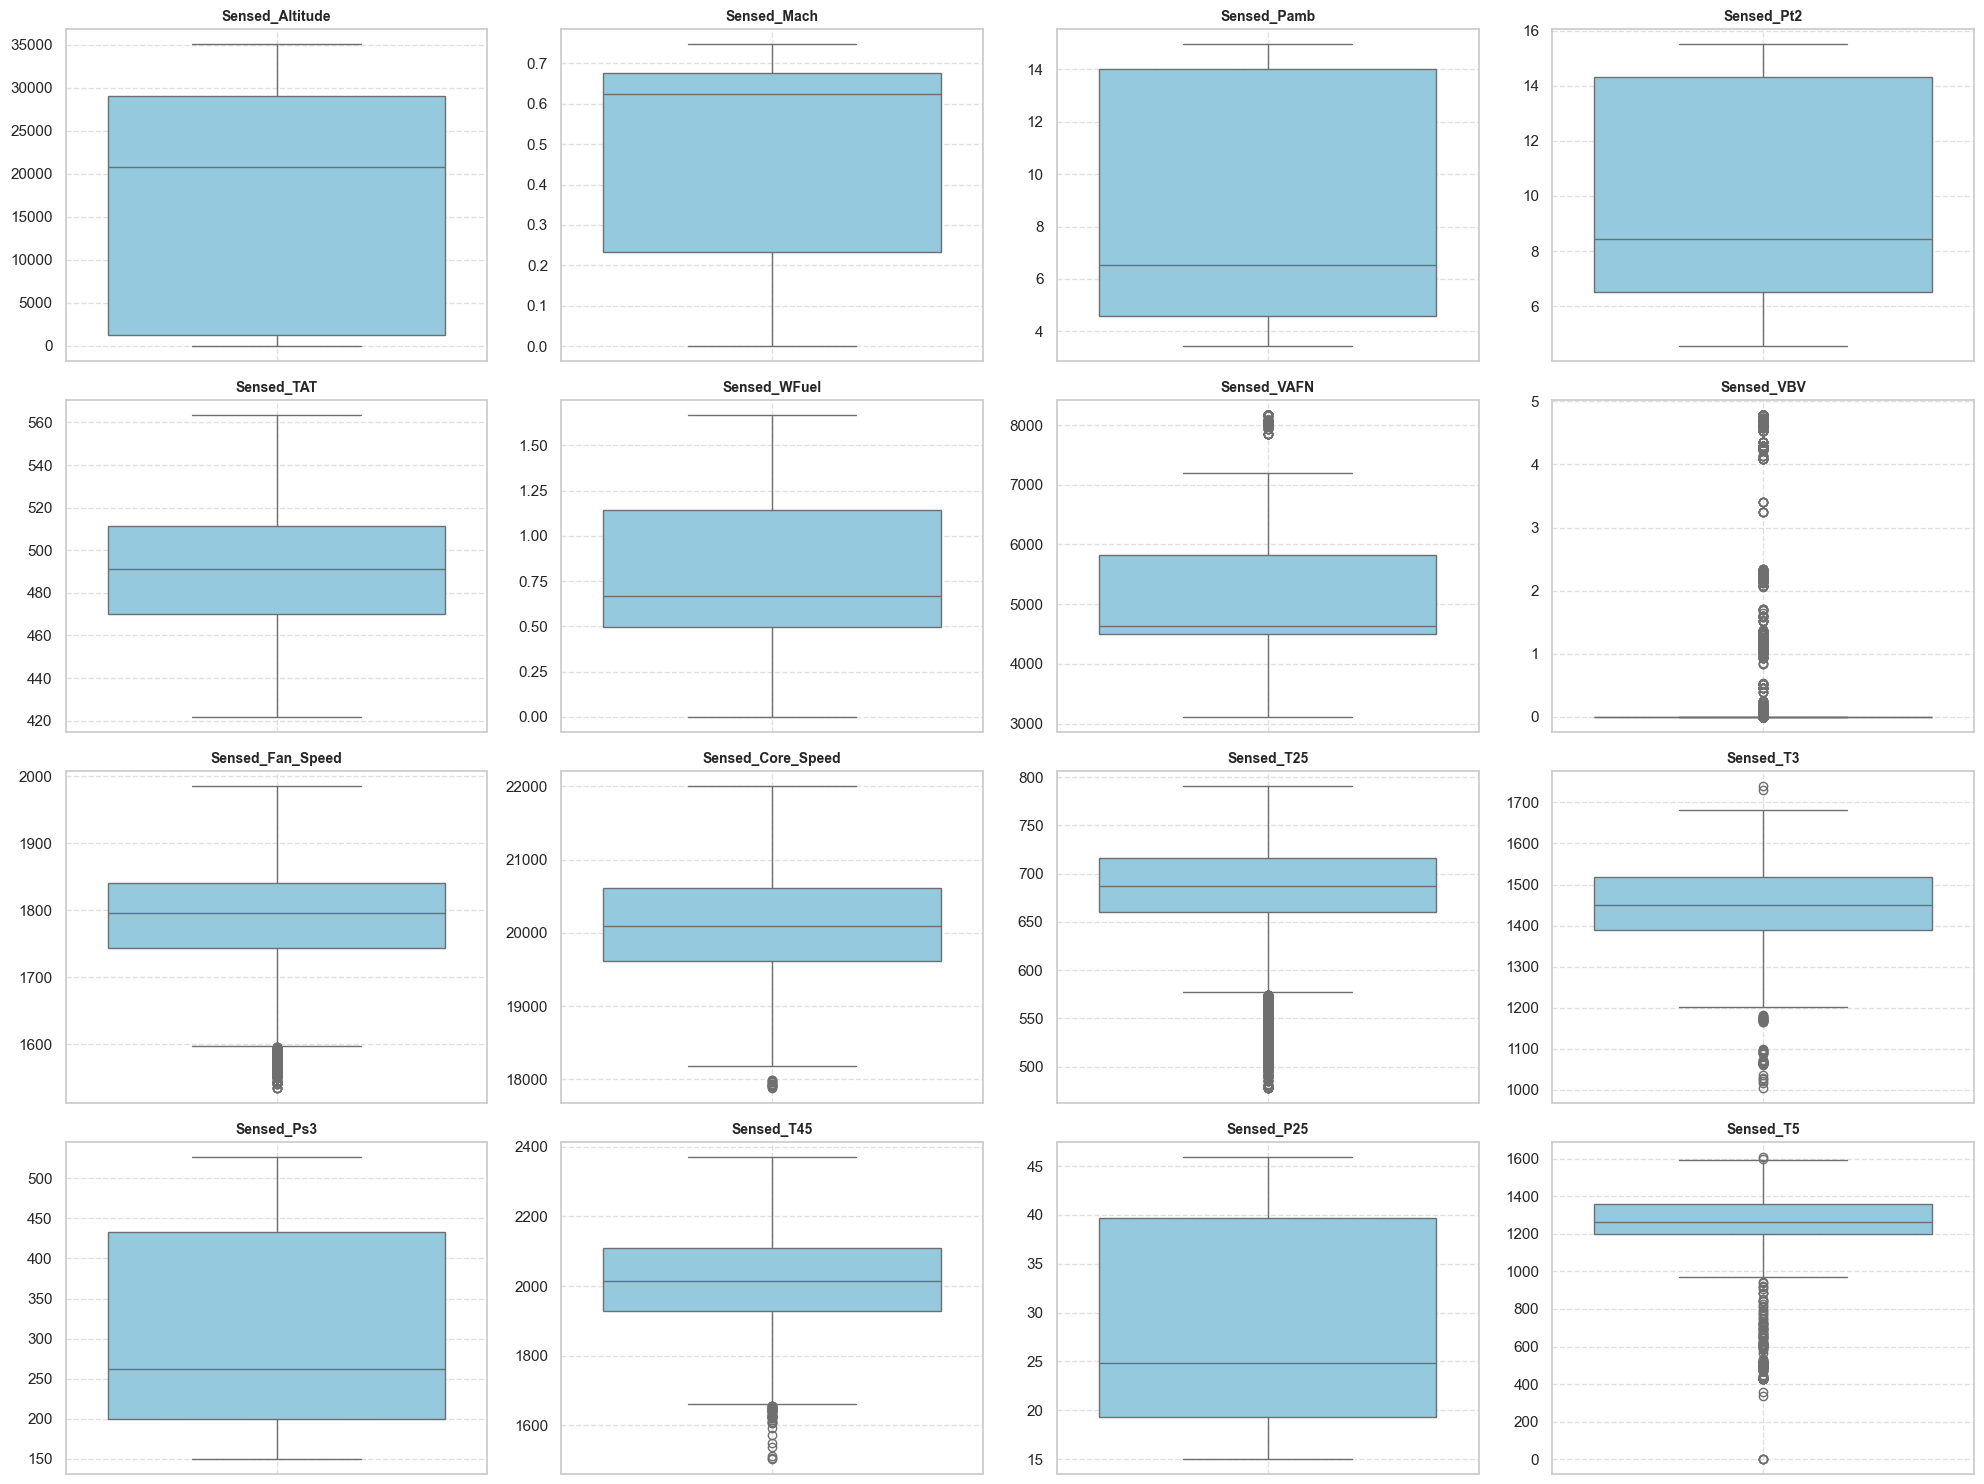

In [7]:
SENSORS_CONFIG = [
    # --- CONDIZIONI OPERATIVE ---
    
    {'name': 'Sensed_Altitude', 'min_phys': 0, 'max_phys': 50000, 'skip_iqr': True, 'clip_min': True},
    {'name': 'Sensed_Mach',     'min_phys': 0.0, 'max_phys': 1.0, 'skip_iqr': True, 'clip_min': True}, 
    {'name': 'Sensed_Pamb',     'min_phys': 0.1, 'max_phys': 16.0, 'skip_iqr': True, 'clip_min': False},
    {'name': 'Sensed_Pt2',      'min_phys': 0.1, 'max_phys': 25.0, 'skip_iqr': True, 'clip_min': False}, 
    {'name': 'Sensed_TAT',      'min_phys': 350.0, 'max_phys': 650.0, 'skip_iqr': True, 'clip_min': False},

    {'name': 'Sensed_WFuel',    'min_phys': 0.0, 'max_phys': 2.0, 'iqr_direction': 'upper', 'iqr_factor': 2.0, 'clip_min': True},
    {'name': 'Sensed_T25',      'min_phys': 0.0, 'max_phys': 2000.0, 'iqr_direction': 'upper', 'iqr_factor': 2.0},
    {'name': 'Sensed_T3',       'min_phys': 1000.0, 'max_phys': 2000.0, 'iqr_direction': 'upper', 'iqr_factor': 1.5},
    {'name': 'Sensed_T45',      'min_phys': 1500.0, 'max_phys': 2400.0, 'iqr_direction': 'upper', 'iqr_factor': 2.0},
    {'name': 'Sensed_T5',       'min_phys': 0.0, 'max_phys': 2000.0, 'iqr_direction': 'upper', 'iqr_factor': 2.0},
    
    {'name': 'Sensed_Core_Speed', 'min_phys': 0.0, 'max_phys': 22000.0, 'iqr_direction': 'both', 'iqr_factor': 1.5, 'clip_min': True},

    {'name': 'Sensed_P25',      'min_phys': 15.0, 'max_phys': 1000.0, 'iqr_direction': 'lower', 'iqr_factor': 1.5},
    {'name': 'Sensed_Ps3',      'min_phys': 150.0, 'max_phys': 1000.0, 'iqr_direction': 'lower', 'iqr_factor': 1.5},
    
    {'name': 'Sensed_Fan_Speed','min_phys': 100.0, 'max_phys': 5000.0, 'iqr_direction': 'lower', 'iqr_factor': 1.5, 'clip_min': True},
    
    {'name': 'Sensed_VAFN',     'min_phys': 0.0, 'max_phys': 10000.0, 'iqr_direction': 'lower', 'iqr_factor': 2.0, 'clip_min': True},
    {'name': 'Sensed_VBV',      'min_phys': 0.0, 'max_phys': 5.0, 'skip_iqr': True, 'clip_min': True}
]

def clean_sensor(df_input, sensor_config):
    """
    Funzione per la pulizia dei dati dei sensori.
    Applica Hard Bounds (con opzione Clipping), IQR Cleaning e Interpolazione.
    """
    df = df_input.copy()
    sensor = sensor_config['name']

    if sensor not in df.columns:
        return df

    print(f"--- Pulizia {sensor} ---")

    # --- 1. HARD BOUNDS (Limiti Fisici) ---
    min_phys = sensor_config.get('min_phys', -np.inf)
    max_phys = sensor_config.get('max_phys', np.inf)
    
    # Opzioni per sostituire col limite (clipping) invece che rimuovere (NaN)
    clip_min = sensor_config.get('clip_min', False)
    clip_max = sensor_config.get('clip_max', False)

    # Gestione Minimo
    mask_min = (df[sensor] < min_phys)
    count_min = mask_min.sum()
    if count_min > 0:
        if clip_min:
            print(f"   -> Clippati {count_min} valori sotto il minimo {min_phys} a {min_phys}.")
            df.loc[mask_min, sensor] = min_phys
        else:
            print(f"   -> Rimossi {count_min} valori sotto il minimo {min_phys}.")
            df.loc[mask_min, sensor] = np.nan

    # Gestione Massimo
    mask_max = (df[sensor] > max_phys)
    count_max = mask_max.sum()
    if count_max > 0:
        if clip_max:
            print(f"   -> Clippati {count_max} valori sopra il massimo {max_phys} a {max_phys}.")
            df.loc[mask_max, sensor] = max_phys
        else:
            print(f"   -> Rimossi {count_max} valori sopra il massimo {max_phys}.")
            df.loc[mask_max, sensor] = np.nan

    # --- 2. STATISTICA ROBUSTA (IQR per Motore) ---
    if not sensor_config.get('skip_iqr', False):
        direction = sensor_config.get('iqr_direction', 'both')
        factor = sensor_config.get('iqr_factor', 1.5)

        for esn in df['ESN'].unique():
            esn_mask = df['ESN'] == esn
            series = df.loc[esn_mask, sensor]
            
            # Se la serie è vuota o tutta NaN, salta
            if series.dropna().empty:
                continue

            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            
            outlier_mask = pd.Series(False, index=series.index)
            if direction in ['lower', 'both']:
                outlier_mask |= (series < (Q1 - factor * IQR))
            if direction in ['upper', 'both']:
                outlier_mask |= (series > (Q3 + factor * IQR))

            count_stat = outlier_mask.sum()
            if count_stat > 0:
                print(f"     ESN {esn}: Rimossi {count_stat} outlier statistici.")
                df.loc[esn_mask & outlier_mask, sensor] = np.nan

    # --- 3. INTERPOLAZIONE ---
    # Interpola i NaN rimanenti (quelli non gestiti dal clipping)
    # limit_direction='forward' riempie i buchi centrali e finali
    # Se il primo dato è NaN (e non è stato clippato), rimarrà NaN
    df[sensor] = df.groupby('ESN')[sensor].transform(
        lambda x: x.interpolate(method='linear', limit_direction='forward', limit_area='inside')
    )
    
    return df

def clean_all_sensors(df):
    df_cleaned = df.copy()
    for config in SENSORS_CONFIG:
        df_cleaned = clean_sensor(df_cleaned, config)
    return df_cleaned

df_clean = clean_all_sensors(df)

# Verifica rapida su un sensore critico (es. P25 che aveva valori negativi)
print(f"Minimo P25 Originale: {df['Sensed_P25'].min()}")
print(f"Minimo P25 Pulito:    {df_clean['Sensed_P25'].min()}") # Deve essere >= 15

# Verifica che non ci siano NaN rimasti (l'interpolazione deve averli riempiti)
print(f"NaN totali rimasti: {df_clean.isna().sum().sum()}") # Deve essere 0 (o molto basso)

# Plotta i sensori puliti
plot_sensor_boxplots(df_clean,sensors_list)

In [8]:
# Salvataggio del DataFrame pulito
output_filename = '../data/temp/00_training_data_cleaned.csv'
df_clean.to_csv(output_filename, index=False)
print(f"\nDataset pulito salvato in: {output_filename}")


Dataset pulito salvato in: ../data/temp/00_training_data_cleaned.csv
